## Import packages

In [2]:
# First import matplotlib (for plotting) and skan
from matplotlib import pyplot as plt
%matplotlib inline
from skan import draw
import numpy as np
from skimage import exposure 

# Then import the radial hydride packagess
from HAPPY import import_image
from HAPPY import cropping_functions as crop
from HAPPY import plot_functions as plt_f
from HAPPY import radial_hydride_fraction as RHF
from HAPPY import branching as branch
from HAPPY import crack_path as cp
from HAPPY import image_processing

/Users/miamaric/opt/anaconda3/lib/python3.8/site-packages/skan/csr.py:21: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @numba.jitclass(csr_spec)


## Importing Image

- First, import the image using the `import_image` command. Transpose the image if necessary using the `transpose` argument to make the radial direction vertical. 
- The `cropImage` function applies a rectangular crop to the image to remove scale bars, or if you have a specific rectangular region you want to look at. 
- Input Scale Bar Value in Scale_Bar_Micron_Value, the scale bar will then be calculated.

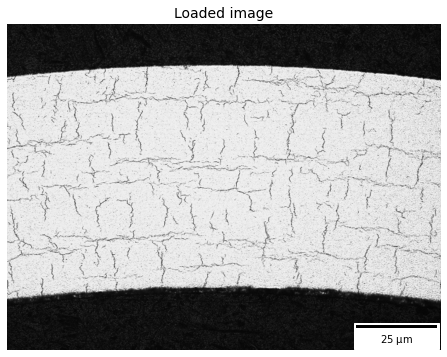

In [119]:
# Load image
original_image = import_image.image(image_path ='data/TM/520-6h.png', transpose = False)
cropped_image = crop.cropImage(original_image, crop_bottom=0, crop_top=0, crop_left=0, crop_right=0)
crop1 = cropped_image
# Input the value of the scale bar in microns
Scale_Bar_Micron_Value = 100
#Input how many pixels are in your scale bar
Pixels_In_Scale_Bar = len(cropped_image)
Scale_Bar_Value_In_Meters = Scale_Bar_Micron_Value*(1e-6)
scale = Scale_Bar_Value_In_Meters/Pixels_In_Scale_Bar 
location = 'lower right'


# Plot image
plt_f.plot(img=cropped_image, title='Loaded image',scale=scale, location=location)

## Additional Cropping

The second crop function is `cropping_tube`, which should be used if the micrograph is curved and removes black pats of the image which are not the tube.

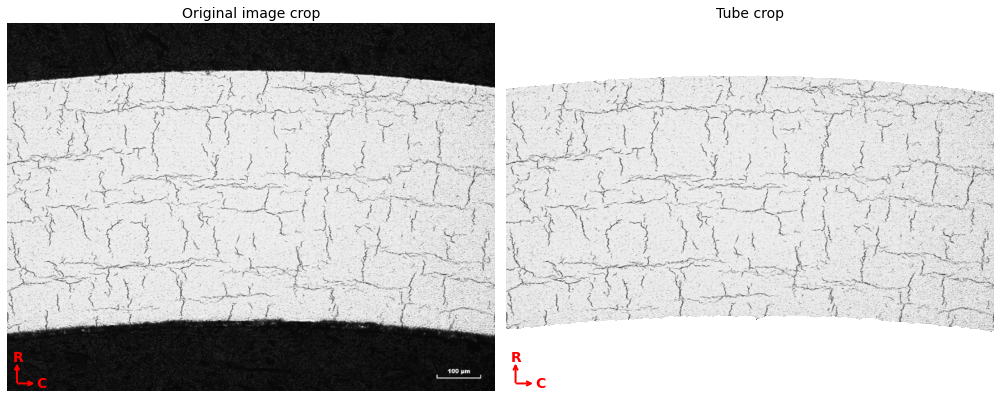

In [120]:
# Crop tube
cropped_image, crop_threshold = crop.cropping_tube(cropped_image, 
                                                   crop_param = 0.1, size_param = 1000, dilation_param = 10)

# Plot comparison
plt_f.plot_comparison(crop1, 'Original image crop', cropped_image, 'Tube crop', 
                   location=location)

## Image Processing

Grain contast or uneven lighting can be minimised through the application of a gaussian blur in the `minimize_grain_contrast` function.

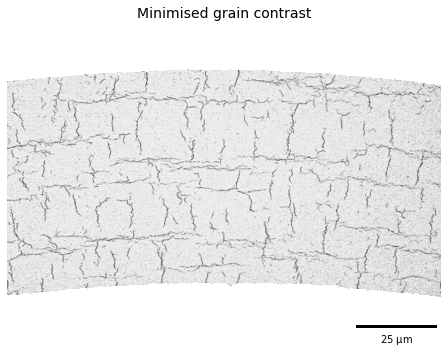

Approximate threshold: 0.959


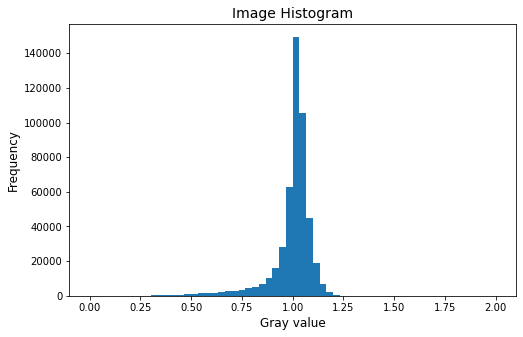

In [121]:
# Remove grain contrast
removed_grains = image_processing.minimize_grain_contrast(cropped_image, sigma = 5)

# Plot image
plt_f.plot(img=cropped_image, title='Minimised grain contrast', scale=scale, location=location)

# Plot the histogram for removed grains so that we can see where we should threshold 
histogram = plt_f.plot_hist(removed_grains)

# Print an approximate threshold value which should work well
print('Approximate threshold: {0:.3f}'.format(
    2*np.nanmedian(removed_grains)-np.nanpercentile(removed_grains, 90)))

## Thresholding

After this, the image is thresholded using the `simple_threshold` function. The threshold value should be set using the `threshold` argument. Small features, less than a given size `small_obj` can optionally be removed. Note it is important not too over threshold the image, guidance of a value to threshold cis shown above and can be determined by investigating the histograms plotted above.

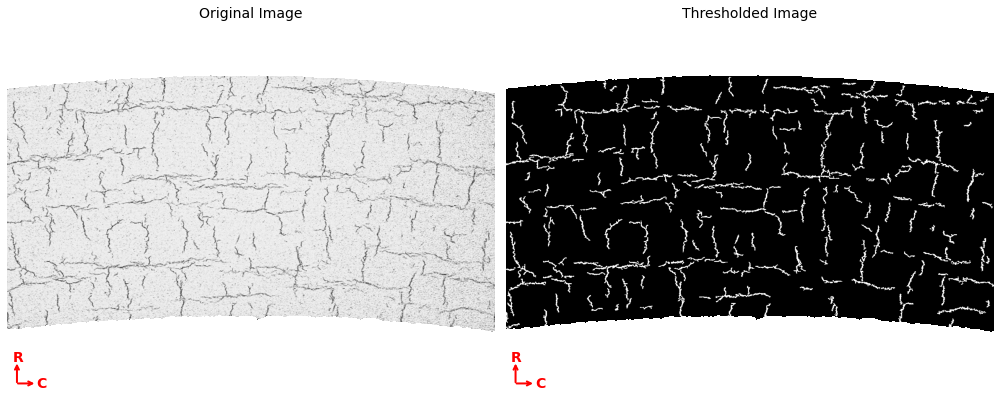

In [122]:
# Apply threshold
thres = image_processing.simple_threshold(removed_grains, crop_threshold, 
                                          threshold = 0.945, small_obj = 50)

# Plot the thresholded image and compare it to the original image: 
plt_f.plot_comparison(cropped_image, 'Original Image', thres,'Thresholded Image', location=location)


## Crack Path

Here we want to determine potential crack paths through the microstrucutre, we input the thresholded image `thres`. After running once, the area around that path (radius set with `kernel_size`) is discounted, then the process is repeated `num_runs` times.

In [123]:
import numpy as np
from scipy import ndimage
from skimage.graph import route_through_array, MCP_Flexible, MCP_Geometric
from skimage.transform import rescale
from scipy.ndimage.morphology import binary_dilation
from skimage.graph import MCP_Flexible


#so here we are creating a new class that is based off MCP flex allowing us to change the functions in it
class My_MCP(MCP_Flexible):   #has a set of functions and variables 

    def __init__(self, costs, offsets=None, fully_connected=True, distance_weight=0):
        self.distance_weight = distance_weight
        super().__init__(
                costs, offsets=offsets, fully_connected=fully_connected
                )     # Based on the skimage.graph MCP_Flexible class

    def travel_cost(self, old_cost, new_cost, offset_length):
        my_cost = new_cost + (self.distance_weight*offset_length)
        return my_cost


def det_crack_path(
        thres,
        crop_threshold,
        num_runs,
        kernel_size,
        distance_weight=0,
        ):
    """Determine possible crack paths in the micrograph.
    Parameters
    ----------
    thres: array
        thesholded image to look at
    crop_threshold: array
        calculated during thresholding, array of true and false values
    num_runs: int
        number of crack paths to determine
    kernel_size: int
        Once a crack is found, all future paths must be at least kernel_size
        away from it.
    distance_weight : float
        Crack paths should follow hydrides but only up to a point: they should
        also be short. This weight determines how much the "shortness"
        consideration should count compared to the hydride. Higher weight =>
        shorter paths.
    Returns
    -------
    edist: array
        min euclidean distace from the hydride to the matrix
    path_list:
        list of possible crack paths
    cost_list: list
        list of cost values for each crack path
    """

    # Use distance away from a hydride as a path to route through
    edist = ndimage.morphology.distance_transform_edt(thres == 0)
    edist = rescale(edist, (1, 1))

    # Add a row of zeros on the top and bottom and set cost=0 outside tube
    edist[0, :] = 0
    edist[-1, :] = 0
    edist = np.where(crop_threshold, 0, edist)

    # Make a empty list to store paths and costs
    path_list = []
    cost_list = []

    for _ in np.arange(num_runs):
        # Coordinates and cost corresponding to path

        m = My_MCP(edist, fully_connected=True, distance_weight=distance_weight)
        # if distance_weight==0, this should behave the same as
        # m = MCP_Geometric(edist, fully_connected=True)
        costs, traceback_array = m.find_costs([(0, 0)] , [(-1,-1)])
        path = np.array(m.traceback((-1, -1)))
        cost = costs[(-1, -1)]

        # old code that we imitated manually with classes above:
        # path, cost = route_through_array(edist, [0, 0], [-1, -1])
        
        # Boolean array based on coordinates, True is on path
        path_array = np.zeros(np.shape(edist), dtype=bool)
        for coord in path:
            path_array[coord[0], coord[1]] = True

        # Take away points outside of crop, make coord array and append to list
        path_array_cropped = np.logical_and(path_array, ~crop_threshold)
        path_coords = np.transpose(np.nonzero(path_array_cropped))
        path_list.append(np.array(path_coords))
        cost_list.append(cost)

        # Filtering path based on kernel size, so that the next run will take
        # a different path
        filter_array = binary_dilation(
            path_array_cropped, iterations=kernel_size
        )
        edist = np.where(filter_array, np.inf, edist)
        edist = np.where(crop_threshold, 0, edist)

    edist = ndimage.morphology.distance_transform_edt(thres == 0)
    edist = rescale(edist, (1, 1))

    return edist, path_list, cost_list


In [139]:
# Determing potential crack paths
edist, path_list, cost_list = det_crack_path(thres, crop_threshold, num_runs=5, kernel_size=5,distance_weight=5)

Run #0	Cost = 8131.41
Run #1	Cost = 8231.12
Run #2	Cost = 8343.19
Run #3	Cost = 8635.83
Run #4	Cost = 8854.66


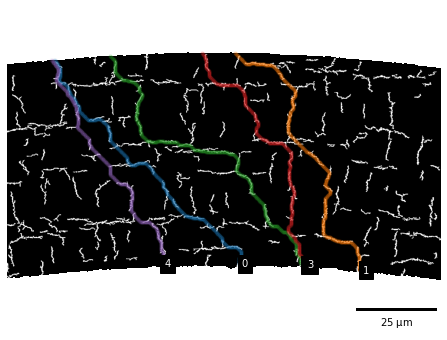

In [140]:
# Plot possible crack paths
fig, ax = plt.subplots(figsize=(10,6))
list_costs = []

for n, (p, c) in enumerate(zip(path_list, cost_list)):
    
    im = ax.imshow(thres, cmap='gray')
    
    #if n==0:
      #  plt.colorbar(im,fraction=0.03, pad=0.01)
    ax.scatter(p[:,1], p[:,0], s=10, alpha=0.1)
    ax.text(p[-1][1], p[-1][0], s=str(n), c='w', bbox=dict(facecolor='black', edgecolor='black'))
    plt.axis('off')
    print('Run #{0}\tCost = {1:.2f}'.format(n,c))
    list_costs.append(c)
    
plt_f.addScaleBar(ax, scale=scale, location=location)
plt_f.addArrows(ax)

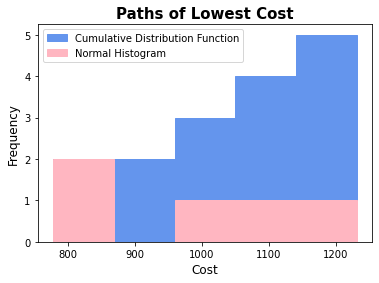

In [126]:
# Histograms for plotting the costs of each path
plt.hist(list_costs, bins=5, cumulative = True, color = "cornflowerblue", ec="cornflowerblue", label = "Cumulative Distribution Function")
plt.hist(list_costs, bins=5, color = "lightpink", ec="lightpink", label = "Normal Histogram")
plt.legend()
plt.xlabel('Cost', fontsize="12")
plt.ylabel('Frequency',fontsize="12")
plt.title('Paths of Lowest Cost', fontweight="bold", fontsize="15")
plt.show()